In [1]:
import os
import math
import sys

import numpy as np
import scipy
from scipy.fft import fft2
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
from hydra import initialize, compose
from pandeia.engine.calc_utils import build_default_calc
from pyHalo.preset_models import CDM

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.analysis import ft, stats
from mejiro.lenses.test import SampleSkyPyLens
from mejiro.plots import plot
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input

In [2]:
array_dir = os.path.join(array_dir, 'sample_skypy_lens')
pickle_dir = os.path.join(pickle_dir, 'pyhalo')

# Different PSFs

In [3]:
no_psf = np.load(os.path.join(array_dir, 'no_psf.npy'))
gaussian_psf = np.load(os.path.join(array_dir, 'gaussian_psf.npy'))
pandeia = np.load(os.path.join(array_dir, 'no_noise_or_background_3_100000.npy'))

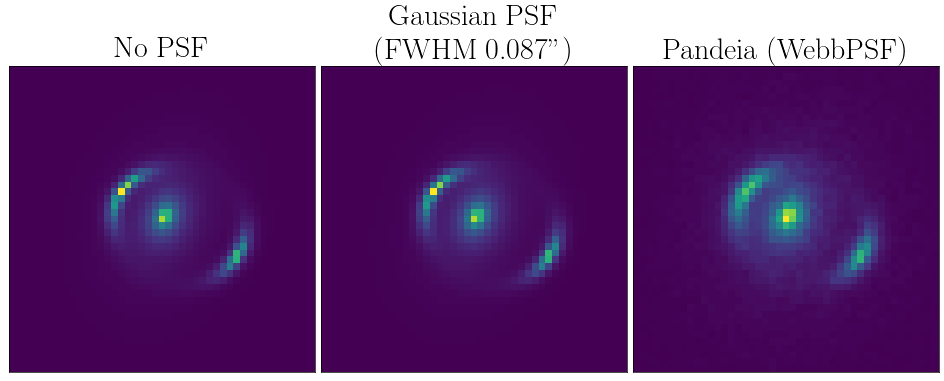

In [4]:
psf_title_list = ['No PSF', 'Gaussian PSF\n(FWHM 0.087\")', 'Pandeia (WebbPSF)']
plot.plot_list([no_psf, gaussian_psf, pandeia], title_list=psf_title_list)

In [5]:
normalized_no_psf = stats.normalize(no_psf)
normalized_gaussian_psf = stats.normalize(gaussian_psf)
normalized_pandeia = stats.normalize(pandeia)

In [6]:
k, power_no_psf, num_modes = ft.twod_ft(normalized_no_psf, 4.95)
_, power_gaussian_psf, _ = ft.twod_ft(normalized_gaussian_psf, 4.95)
_, power_pandeia, _ = ft.twod_ft(normalized_pandeia, 4.95)


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


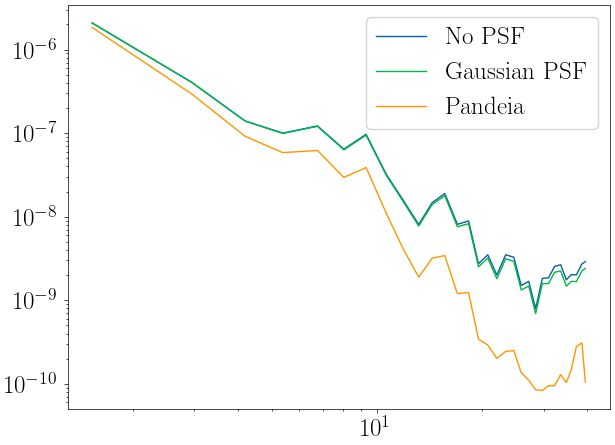

In [7]:
fig, ax = plt.subplots()

ax.loglog(k, power_no_psf, label='No PSF')
ax.loglog(k, power_gaussian_psf, label='Gaussian PSF')
ax.loglog(k, power_pandeia, label='Pandeia')
ax.legend()

In [8]:
band = 'f106'
num_samples = 100000
grid_supersample = 3

lens = SampleSkyPyLens()

In [9]:
# generate subhalos
subhalos = CDM(lens.z_lens, 
             lens.z_source, 
             cone_opening_angle_arcsec=6., 
             LOS_normalization=0., 
             log_mlow=6., 
             log_mhigh=10.)

In [27]:
def cut_mass(realization, log_m_cutoff):
    for i, halo in enumerate(realization.halos):
        if halo.mass < 10 ** log_m_cutoff:
            del realization.halos[i]

    return realization

In [28]:
from copy import deepcopy

no_cut = deepcopy(subhalos)
cut_7 = cut_mass(deepcopy(subhalos), 7)
cut_8 = cut_mass(deepcopy(subhalos), 8)

In [19]:
no_cut_masses = [halo.mass for halo in no_cut.halos]
cut_7_masses = [halo.mass for halo in cut_7.halos]
cut_8_masses = [halo.mass for halo in cut_8.halos]

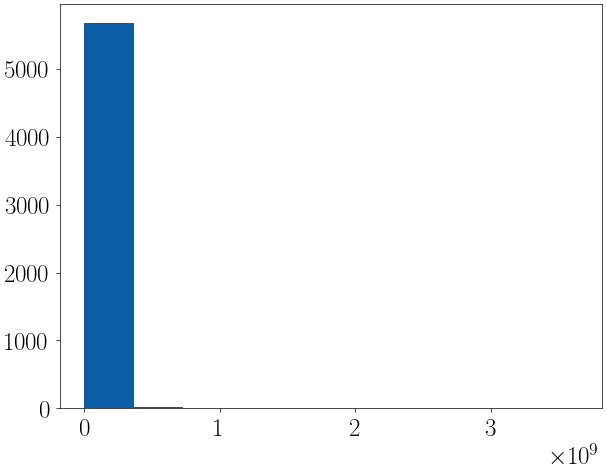

In [25]:
plt.hist(no_cut_masses, bins=10)
plt.show()

In [48]:
from copy import deepcopy

no_cut_lens = deepcopy(lens)
cut_7_lens = deepcopy(lens)
cut_8_lens = deepcopy(lens)

lenses = [no_cut_lens, cut_7_lens, cut_8_lens]

In [49]:
no_cut_model = no_cut_lens.get_array(num_pix=51 * grid_supersample, side=5.61)
cut_7_model = cut_7_lens.get_array(num_pix=51 * grid_supersample, side=5.61)
cut_8_model = cut_8_lens.get_array(num_pix=51 * grid_supersample, side=5.61)

models = [no_cut_model, cut_7_model, cut_8_model]

In [50]:
titles = ['substructure_no_cut', 'substructure_cut_7', 'substructure_cut_8']

for lens, model, title in zip(lenses, models, titles):
    calc = build_default_calc('roman', 'wfi', 'imaging')

    # set scene size settings
    calc['configuration']['max_scene_size'] = 5

    # set instrument
    calc['configuration']['instrument']['filter'] = band

    # set detector
    calc['configuration']['detector']['ma_table_name'] = 'hlwas_imaging'

    # turn off noise sources
    calc['calculation'] = pandeia_input.get_calculation_dict(init=False)

    # set background
    calc['background'] = 'none'

    # convert array from counts/sec to astronomical magnitude
    mag_array = pandeia_input._get_mag_array(lens, model, num_samples, band, suppress_output=False)

    # add point sources to Pandeia input
    norm_wave = pandeia_input._get_norm_wave(band)
    calc, num_point_sources = pandeia_input._phonion_sample(calc, mag_array, lens, num_samples, norm_wave)

    # get Pandeia image
    pandeia, _ = pandeia_input.get_pandeia_image(calc)

    np.save(os.path.join(array_dir, f'{title}.npy'), pandeia)

 12%|█▏        | 1428/11452 [00:08<01:00, 167.03it/s]


KeyboardInterrupt: 

In [ ]:
pandeia = np.load(os.path.join(array_dir, 'no_noise_or_background_3_100000.npy'))

In [ ]:
plot.plot(title='Pandeia',
          array=pandeia,
          colorbar=True)